In [39]:
import openmm
from ipywidgets import Image
from openff.interchange.components._packmol import (
    RHOMBIC_DODECAHEDRON,
    solvate_topology,
)
from openff.toolkit import ForceField, Molecule, Topology
from openff.units import Quantity
from rdkit.Chem import Draw
from rdkit.Chem.rdChemReactions import ReactionFromSmarts

In [34]:
with open('system.pdb') as of:
    with open('system_edited.pdb','w') as ofw:
        for line in of.readlines():
            to_write = line.strip()
            #to_write = to_write.replace("TH4", "THR").
            #    replace("LY6", "LYS").
            #    replace("SE9", "SER").
            #    replace("A10", "ASP").
            #    replace("G12", "GLU").
            #    replace("G13", "GLU") 
            if "ATOM" in to_write:
                #if "A10" in to_write:
                #    to_write = to_write.replace("HB3", "HB1")
                if "G12" in to_write:
                    if "OE2" in to_write:
                        to_write = to_write.replace("OE2", "OE1")
                #if "LY6" in to_write:
                #    if "HZ" in to_write:
                #        to_write = to_write.replace("HZ", "HZ1")

                to_write += ' '*10 + line.split()[2][0]
            if to_write == "TER":
                #to_write = 'TER\n' 
                # Example "CONECT 2617 2592"
                #TH4 OG1 to A10 CG
                to_write += 'CONECT   43  142'
                to_write += '\nCONECT  142   43'
                #LY6 NZ to G13 CD
                to_write += '\nCONECT   86  194'
                to_write += '\nCONECT  194   86'
                # SE9 OG to G12 CD
                to_write += '\nCONECT  132  180'
                to_write += '\nCONECT  180  132'
                
                
            to_write += '\n'
            ofw.write(to_write)

In [35]:
from openff.pablo import CCD_RESIDUE_DEFINITION_CACHE, topology_from_pdb
from openff.pablo.residue import BondDefinition

custom_residue_database = CCD_RESIDUE_DEFINITION_CACHE.with_(
    {
        "TH4": [
            resdef.replace(
                residue_name="TH4",
                crosslink=BondDefinition.with_defaults(atom1="OG1", atom2="CG"),
                atoms=[
                    atom.replace(leaving=True) if atom.name == "HG1" else atom
                    for atom in resdef.atoms
                ],
                description=resdef.description + " w/ crosslink",
            )
            for resdef in CCD_RESIDUE_DEFINITION_CACHE["THR"]
            if resdef.description == "THREONINE"
        ],
        "A10": [
            resdef.replace(
                residue_name="A10",
                crosslink=BondDefinition.with_defaults(atom1="CG", atom2="OG1"),
                atoms=[
                    (
                        atom.replace(leaving=True)
                        if atom.name in {"OD2", "HD2"}
                        else atom
                    )
                    for atom in resdef.atoms
                ],
                description=resdef.description + " w/ crosslink",
            )
            for resdef in CCD_RESIDUE_DEFINITION_CACHE["ASP"]
            if resdef.description == "ASPARTIC ACID"
        ],
        "LY6": [
            resdef.replace(
                residue_name="LY6",
                crosslink=BondDefinition.with_defaults(atom1="NZ", atom2="CD"),
                atoms=[
                    (
                        atom.replace(leaving=True)
                        if atom.name in {"HZ2", "HZ3"}
                        else (
                            atom.replace(synonyms=(*atom.synonyms, "HZ"))
                            if atom.name == "HZ1"
                            else atom
                        )
                    )
                    for atom in resdef.atoms
                ],
                description=resdef.description + " w/ crosslink",
            )
            for resdef in CCD_RESIDUE_DEFINITION_CACHE["LYS"]
            if resdef.description == "LYSINE -HZ3"
        ],
        "G13": [
            resdef.replace(
                residue_name="G13",
                crosslink=BondDefinition.with_defaults(atom1="CD", atom2="NZ"),
                atoms=[
                    atom.replace(leaving=True)
                    if atom.name in ("OE2", "HE2")
                    else atom
                    for atom in resdef.atoms
                ],
                description=resdef.description + " w/ crosslink",
            )
            for resdef in CCD_RESIDUE_DEFINITION_CACHE["GLU"]
            if resdef.description == "GLUTAMIC ACID"
        ],
        "SE9": [
            resdef.replace(
                residue_name="SE9",
                crosslink=BondDefinition.with_defaults(atom1="OG", atom2="CD"),
                atoms=[
                    atom.replace(leaving=True) if atom.name == "HG" else atom
                    for atom in resdef.atoms
                ],
                description=resdef.description + " w/ crosslink",
            )
            for resdef in CCD_RESIDUE_DEFINITION_CACHE["SER"]
            if resdef.description == "SERINE"
        ],
        "G12": [
            resdef.replace(
                residue_name="G12",
                crosslink=BondDefinition.with_defaults(atom1="CD", atom2="OG"),
                atoms=[
                    atom.replace(leaving=True)
                    if atom.name in ("OE2", "HE2")
                    else atom
                    for atom in resdef.atoms
                ],
                description=resdef.description + " w/ crosslink",
            )
            for resdef in CCD_RESIDUE_DEFINITION_CACHE["GLU"]
            if resdef.description == "GLUTAMIC ACID"
        ],
    },
)

top = topology_from_pdb(
    "system_edited.pdb",
    residue_database=custom_residue_database,
)


In [36]:
top.molecule(0)

NGLWidget()

In [41]:
top = solvate_topology(
    top,
    nacl_conc=Quantity(0.1, "mol/L"),
    padding=Quantity(1.2, "nm"),
    box_shape=RHOMBIC_DODECAHEDRON,
)

In [42]:
top.visualize()

NGLWidget()

In [43]:
from ptm_prototype import parametrize_with_nagl
from openff.toolkit import ForceField

sage_ff14sb = ForceField("openff-2.2.1.offxml", "ff14sb_off_impropers_0.0.4.offxml")


interchange = parametrize_with_nagl(force_field=sage_ff14sb, topology=top)

adding dummy charges to force field ...
making Interchange ...
replacing dummy charges with NAGL charges ... 
assigning graph charges to C78H104N19O21 ...


[11:41:33] WARNING: Proton(s) added/removed



continuing with dummy charge replacement ...


In [61]:
print([*interchange['Electrostatics'].key_map.values()][0])
print([*interchange['Electrostatics'].key_map.values()][-1])

id='[H:6][C:5]([C:20]=[O:21])([C:7]([H:8])([C:9]([H:10])([H:11])[H:12])[C:13]([H:14])([H:15])[C:16]([H:17])([H:18])[H:19])[N+:1]([H:2])([H:3])[H:4]' mult=0 associated_handler='LibraryCharges' bond_order=None virtual_site_type=None cosmetic_attributes={}
id='inserted_graph_charges' mult=196 associated_handler='molecules_with_preset_charges' bond_order=None virtual_site_type=None cosmetic_attributes={}


In [44]:
from ptm_prototype import get_openmm_total_charge

temperature = 300 * openmm.unit.kelvin
pressure = 1 * openmm.unit.bar

timestep = 2 * openmm.unit.femtosecond
friction_coeff = 1 / openmm.unit.picosecond
barostat_frequency = 25

print("making OpenMM simulation ...")
simulation = interchange.to_openmm_simulation(
    integrator=openmm.LangevinMiddleIntegrator(
        temperature,
        friction_coeff,
        timestep,
    ),
    additional_forces=[
        openmm.MonteCarloBarostat(
            pressure,
            temperature,
            barostat_frequency,
        ),
    ],
)

dcd_reporter = openmm.app.DCDReporter("trajectory.dcd", 100)
simulation.reporters.append(dcd_reporter)

print(f"total system charge is {get_openmm_total_charge(simulation.system)}")

print("serializing OpenMM system ...")
with open("system.xml", "w") as f:
    f.write(openmm.XmlSerializer.serialize(simulation.system))

making OpenMM simulation ...
total system charge is 7.993605777301127e-15
serializing OpenMM system ...


In [45]:
simulation.context.computeVirtualSites()
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(simulation.integrator.getTemperature())

In [46]:
simulation.runForClockTime(.25 * openmm.unit.minute)

In [50]:
from ptm_prototype import nglview_show_openmm

w = nglview_show_openmm(simulation.topology, "trajectory.dcd")
w.add_licorice("not UNK", radius=0.3)
#w.center("not water")
w

NGLWidget(max_frame=146)

In [29]:
from ptm_prototype import react
from ptm_prototype import draw_molecule


def draw_mol_with_atom_names(mol_to_draw):
    return draw_molecule(
        mol_to_draw,
        width=700,
        height=600,
        atom_notes={
            i: (
                f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
                + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
            )
            for i, atom in enumerate(mol_to_draw.atoms)
        },
    )

LYSINE -H2 -HZ3


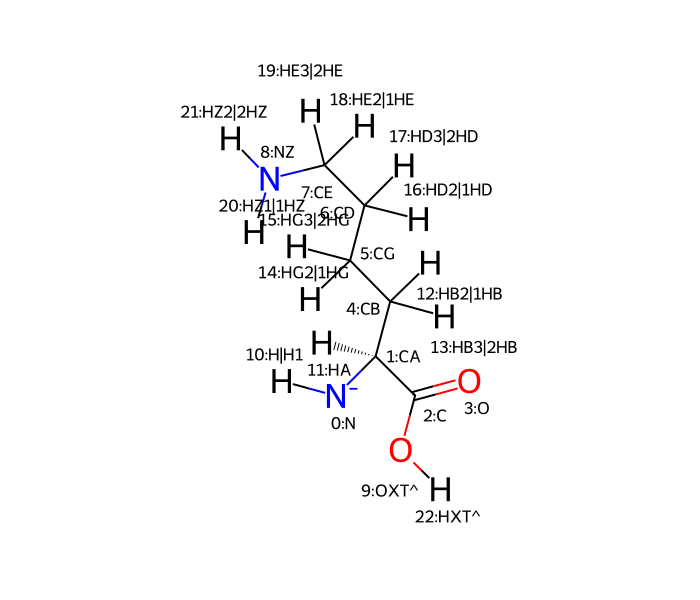

In [32]:
mol = CCD_RESIDUE_DEFINITION_CACHE['LYS'][6].to_openff_molecule()
print(mol.properties["description"])
draw_mol_with_atom_names(mol)

In [33]:
for template in CCD_RESIDUE_DEFINITION_CACHE['LYS']:
    print(template.to_openff_molecule().properties['description'])

LYSINE
LYSINE -HXT
LYSINE -H2
LYSINE -HXT -H2
LYSINE -HZ3
LYSINE -HXT -HZ3
LYSINE -H2 -HZ3
LYSINE -HXT -H2 -HZ3
LYSINE +H3
LYSINE -HXT +H3
LYSINE -H2 +H3
LYSINE -HXT -H2 +H3
LYSINE -HZ3 +H3
LYSINE -HXT -HZ3 +H3
LYSINE -H2 -HZ3 +H3
LYSINE -HXT -H2 -HZ3 +H3
